In [1]:
%matplotlib inline


# Sensor-level RSA using a searchlight

This example demonstrates how to perform representational similarity analysis
(RSA) on EEG data, using a searchlight approach.

In the searchlight approach, representational similarity is computed between
the model and searchlight "patches". A patch is defined by a seed point (e.g.
sensor Pz) and everything within the given radius (e.g. all sensors within 4
cm. of Pz). Patches are created for all possible seed points (e.g. all
sensors), so you can think of it as a "searchlight" that moves from seed
point to seed point and everything that is in the spotlight is used in the
computation.

The radius of a searchlight can be defined in space, in time, or both. In
this example, our searchlight will have a spatial radius of 4.5 cm. and a
temporal radius of 50 ms.

The dataset will be the kiloword dataset [1]_: approximately 1,000 words were
presented to 75 participants in a go/no-go lexical decision task while
event-related potentials (ERPs) were recorded.

.. [1] Dufau, S., Grainger, J., Midgley, KJ., Holcomb, PJ (2015). A thousand
       words are worth a picture: Snapshots of printed-word processing in an
       event-related potential megastudy. Psychological science.


In [2]:
# sphinx_gallery_thumbnail_number=2

# Import required packages
import mne
import mne_rsa

MNE-Python contains a build-in data loader for the kiloword dataset. We use
it here to read it as 960 epochs. Each epoch represents the brain response to
a single word, averaged across all the participants. For this example, we
speed up the computation, at a cost of temporal precision, by downsampling
the data from the original 250 Hz. to 100 Hz.



In [10]:
data_path = mne.datasets.kiloword.data_path(verbose=True)
epochs = mne.read_epochs(data_path / 'kword_metadata-epo.fif')
epochs = epochs.resample(100)

Reading C:\Users\SilverBullet\mne_data\MNE-kiloword-data\kword_metadata-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -100.00 ...     920.00 ms
        0 CTF compensation matrices available
Adding metadata with 8 columns
960 matching events found
No baseline correction applied
0 projection items activated


The kiloword datas was erroneously stored with sensor locations given in
centimeters instead of meters. We will fix it now. For your own data, the
sensor locations are likely properly stored in meters, so you can skip this
step.



In [11]:
'''
这段代码是Python中的一段循环，用于处理一个名为epochs的对象中的信息。这个对象似乎来自于MNE-Python，一个用于处理电生理信号（如脑电图EEG、磁脑图MEG等）的Python库。

让我们逐行解释这段代码：

for ch in epochs.info['chs']: 这是一个for循环，它遍历epochs.info['chs']中的每一个元素。在这里，epochs是一个MNE Epochs对象，它包含了一系列的事件相关的数据。info是一个字典，包含了关于数据的元数据，如采样率、通道类型等。'chs'是info字典中的一个键，对应的值是一个列表，包含了每个通道的信息。

ch['loc'] /= 100 这行代码修改了每个通道信息（ch）中的'loc'字段。'loc'字段通常包含了关于通道位置的信息。/=操作符是Python中的除法赋值操作符，它将'loc'字段的值除以100，然后将结果赋值回'loc'字段。这可能是为了将位置信息从一种单位（如毫米）转换为另一种单位（如厘米）。
'''
for ch in epochs.info['chs']:
    ch['loc'] /= 100

The ``epochs`` object contains a ``.metadata`` field that contains
information about the 960 words that were used in the experiment. Let's have
a look at the metadata for the 10 random words:



In [12]:
epochs.metadata.sample(10)

,WORD,Concreteness,WordFrequency,OrthographicDistance,NumberOfLetters,BigramFrequency,ConsonantVowelProportion,VisualComplexity
773,cause,2.75,3.122216,1.75,5.0,588.400,0.400,70.442860
202,southern,3.90,2.897627,2.90,8.0,704.125,0.625,63.389497
315,grave,5.25,2.432969,1.25,5.0,596.400,0.600,70.063945
293,reach,3.65,2.531479,1.45,5.0,964.400,0.600,66.407410
458,monument,5.60,2.278754,2.70,8.0,611.000,0.625,72.044648
769,blood,6.00,3.404320,1.70,5.0,320.400,0.600,69.360261
814,hedge,5.55,2.252853,1.75,5.0,361.800,0.600,82.118407
512,pity,2.30,2.710117,1.70,4.0,261.000,0.500,60.360848
707,duration,3.25,2.130334,2.35,8.0,607.125,0.500,61.138663
437,decision,3.60,3.246499,2.40,8.0,647.750,0.500,63.954769


Let's pick something obvious for this example and build a dissimilarity
matrix (DSM) based on the number of letters in each word.



In [ ]:
'''
用metadata来生成RDM
所以本质上也是欧式距离了.


'''
from scipy.spatial import distance
dsm_vis = mne_rsa.compute_dsm(epochs.metadata[['NumberOfLetters']],
                              metric='euclidean')
mne_rsa.plot_dsms(dsm_vis)
dsm_vis_2D = distance.squareform(dsm_vis)


In [17]:
'''

测试一下 squareform 函数.


scipy.spatial.distance.squareform 这个函数的反运算的函数有吗
ChatGPT
是的，scipy.spatial.distance.squareform 函数实际上是可以进行双向操作的。它不仅可以将一维的距离向量转换为二维的距离矩阵，也可以将二维的距离矩阵转换为一维的距离向量。

当你将一个二维的距离矩阵作为输入传递给 scipy.spatial.distance.squareform 函数时，它会返回一个一维的距离向量。这个向量包含了距离矩阵的下三角部分（不包括对角线）的所有元素。

这是因为在一个距离矩阵中，上三角和下三角部分是对称的，所以只需要存储其中的一部分就足够了。这样可以节省存储空间，也可以加快计算速度。

例如：
'''

# import numpy as np
# from scipy.spatial import distance
#
# # 创建一个二维距离矩阵
# matrix = np.array([[0, 1, 2], [1, 0, 3], [2, 3, 0]])
#
# # 使用 squareform 函数将二维矩阵转换为一维向量
# vector = distance.squareform(matrix)
#
# print(vector)


[1 2 3]


The above DSM will serve as our "model" DSM. In this example RSA analysis, we
are going to compare the model DSM against DSMs created from the EEG data.
The EEG DSMs will be created using a "searchlight" pattern. We are using
squared Euclidean distance for our DSM metric, since we only have a few data
points in each searchlight patch. Feel free to play around with other metrics.



In [14]:
rsa_result = mne_rsa.rsa_epochs(
    epochs,                           # The EEG data
    dsm_vis,                          # The model DSM
    epochs_dsm_metric='sqeuclidean',  # Metric to compute the EEG DSMs
    rsa_metric='kendall-tau-a',       # Metric to compare model and EEG DSMs
    spatial_radius=0.45,              # Spatial radius of the searchlight patch in meters.
    temporal_radius=0.05,             # Temporal radius of the searchlight path in seconds.
    tmin=0.15, tmax=0.25,             # To save time, only analyze this time interval
    n_jobs=1,                         # Only use one CPU core. Increase this for more speed.
    n_folds=None,                     # Don't use any cross-validation
    verbose=False)                    # Set to True to display a progress bar

Performing RSA between Epochs and 1 model DSM(s)
    Spatial radius: 0.45 meters
    Using 29 sensors
    Temporal radius: 5 samples
    Time inverval: 0.15-0.25 seconds
Automatic dermination of folds: 1 (no cross-validation)
Creating spatio-temporal searchlight patches


The result is packed inside an MNE-Python :class:`mne.Evoked` object. This
object defines many plotting functions, for example
:meth:`mne.Evoked.plot_topomap` to look at the spatial distribution of the
RSA values. By default, the signal is assumed to represent micro-Volts, so we
need to explicitly inform the plotting function we are plotting RSA values
and tweak the range of the colormap.



C:\Users\SilverBullet\AppData\Local\Temp\ipykernel_6176\2054706602.py:1: FutureWarning: The "vmin" and "vmax" parameters are deprecated and will be removed in version 1.3. Use the "vlim" parameter instead.
  rsa_result.plot_topomap(rsa_result.times, units=dict(eeg='kendall-tau-a'),


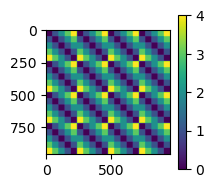

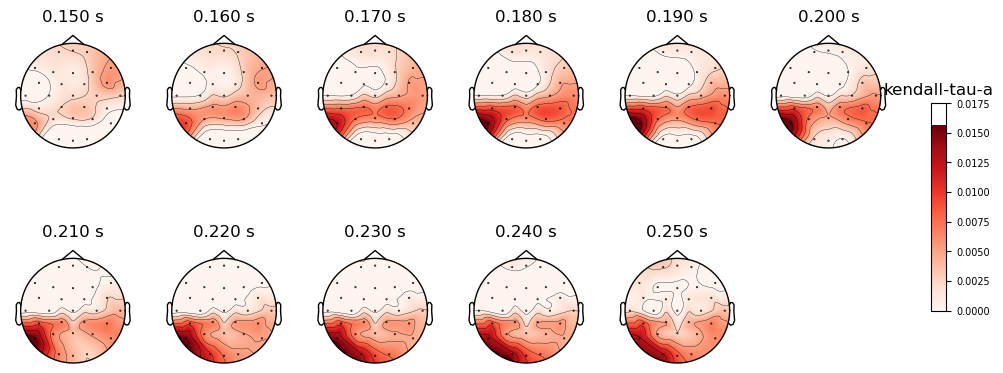

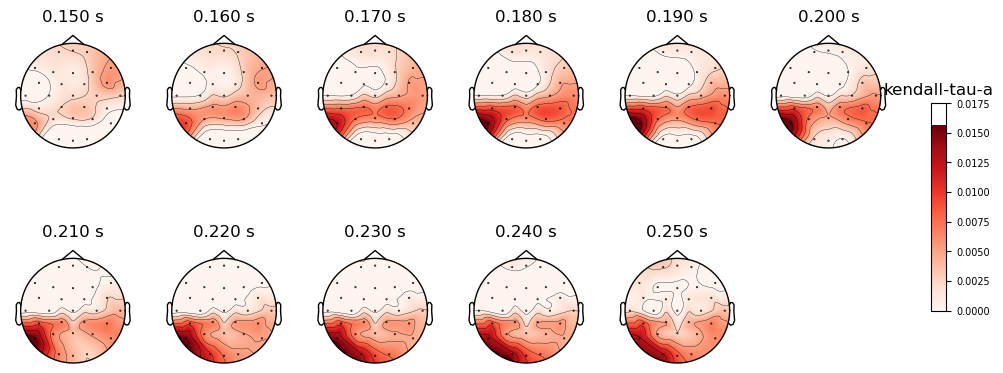

In [15]:
rsa_result.plot_topomap(rsa_result.times, units=dict(eeg='kendall-tau-a'),
                        scalings=dict(eeg=1), cbar_fmt='%.4f', vmin=0, nrows=2,
                        sphere=1)

Unsurprisingly, we get the highest correspondance between number of letters
and EEG signal in areas in the [visual word form area](https://en.wikipedia.org/wiki/Visual_word_form_area).

